# GridWorld from homework01

In [1]:
import numpy as np

# inspired by: https://github.com/MJeremy2017/reinforcement-learning-implementation/blob/master/GridWorld/gridWorld.py
BOARD_ROWS = 3
BOARD_COLS = 5
# states = 3x5
WIN_STATE = (0, 2)
LOSE_STATE_I = (1, 0)
LOSE_STATE_II = (1, 4)
START = (2, 2)
WALL = (1, 2)
DETERMINISTIC = True

class GridWorld(): 
    def __init__(self, state=START):
        # Initialize GridWorld board
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])

        self.state = state
        self.det = DETERMINISTIC
        
    def giveReward(self):
        if self.state == WIN_STATE:
            return 1
        elif (self.state == LOSE_STATE_I) or (self.state == LOSE_STATE_II):
            return -1
        else:
            return 0

    def nextPosition(self, action):
        """
        action: up, down, left, right
        return: next position
        """
        if self.det:
            if action == 0:
                nextState = (self.state[0] - 1, self.state[1])
            elif action == 1:
                nextState = (self.state[0] + 1, self.state[1])
            elif action == 2:
                nextState = (self.state[0], self.state[1] - 1)
            else: 
                nextState = (self.state[0], self.state[1] + 1)
            # if next state legal aka. if field is free
            if (nextState[0] >= 0) and (nextState[0] <= (BOARD_ROWS -1)):  
                if (nextState[1] >= 0) and (nextState[1] <= (BOARD_COLS -1)):
                    if nextState != WALL:
                        return nextState
            return self.state

    def showBoard(self):
        """Show the GridWorld playfield in ASCII art"""
        self.board[self.state] = 1
        # Wall / barrier
        self.board[WALL] = -1
        # Win / Lose states
        self.board[WIN_STATE] = 2
        self.board[LOSE_STATE_I] = -2
        self.board[LOSE_STATE_II] = -2
        for i in range(0, BOARD_ROWS):
            print('-----------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                # Player
                if self.board[i, j] == 1:
                    token = '*'
                # Wall / barrier
                if self.board[i, j] == -1:
                    token = 'z'
                # Free fields
                if self.board[i, j] == 0:
                    token = '0'
                # Win state
                if self.board[i, j] == 2:
                    token = 'W'
                # Lose state
                if self.board[i, j] == -2:
                    token = 'L'
                out += token + ' | '
            print(out)
        print('-----------------')

GW = GridWorld()

# 2 Learning a policy via MC - Policy Iteration

In [11]:
def SARSA_One(Q_old, r, Q_old_dash):
    alpha = 0.2 # what is alpha?
    gamma = 1
    Q_new = Q_old + alpha * (r + gamma * Q_old_dash - Q_old)
    return Q_new

In [15]:
class Agent():
    def __init__(self):
        self.GW = GridWorld()
        self.end = False

        # Initialize epsilon and epsilon-decay
        self.epsilon = 1
        self.decay = 0.999

        # Initialize dictionary to safe returns
        self.returns = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                for k in range(4):
                    self.returns[(i, j), k] = [0,0] 

        # Initialize q-value table
        self.q_values = np.random.uniform(size=(3,5,4))
    
    def policy(self, epsilon, state):
        # Epsilon-greedy policy to coose action
        if np.random.rand() > epsilon:
          action = np.argmax(self.q_values[state])
        else:
          action = np.random.randint(0,4)
        return action

    def makeAct(self):
        # Choose action
        self.action = self.policy(self.epsilon, self.GW.state)

        # Make action
        self.GW.state = self.GW.nextPosition(self.action)
        self.reward = self.GW.giveReward()
        if self.reward==1 or self.reward==-1:
            # End game
            self.end = True
    
    def reset(self):
        self.GW = GridWorld()
        self.end = False

    def play(self):
        i = 0
        # Create empty list to safe state of agent and action taken
        self.state_action_list = []

        while self.end==False:
            # Safe state before the action is taken
            last_state = self.GW.state
            self.makeAct()

            # Pair state and action 
            # EDIT: and new state
            self.state_action_list.append((last_state, self.action, self.reward, self.GW.state))
            # Decay epsilon after every turn
            self.epsilon *= self.decay

            i += 1
            # safety mechanism to prevent endless loop
            if i > 1000:
                self.reward = -1
                break

        
        for s,a,r, s_dash in self.state_action_list:
            try:
                # Update q-values
                #self.q_values[s[0],s[1],a] = round(self.returns[s,a][0]/self.returns[s,a][1],3)
                # EDIT: SARSA method
                # FIXME: what action does Q_dash has? Do I have to store that somewhere?? 
                # I'll just pick the highest value here
                self.q_values[s[0], s[1], a] = SARSA_One(self.q_values[s[0], s[1], a], r, max(self.q_values[s_dash[0], s_dash[1]]))
                
            except:
                # Prevent division by 0
                self.q_values[s[0],s[1],a] = 0

        self.reset()


In [16]:
import time
ag = Agent()
ag.play()
GW.showBoard()

# Returns per episode
results = []
# Avg. returns per episode
rpe = []
# wallclock
times = []
start_time = time.time()

episodes = 1000

for k in range(episodes):
    ag.play()
    results.append(ag.reward)
    rpe.append(np.mean(results))
    times.append(time.time()-start_time)


-----------------
| 0 | 0 | W | 0 | 0 | 
-----------------
| L | 0 | z | 0 | L | 
-----------------
| 0 | 0 | * | 0 | 0 | 
-----------------


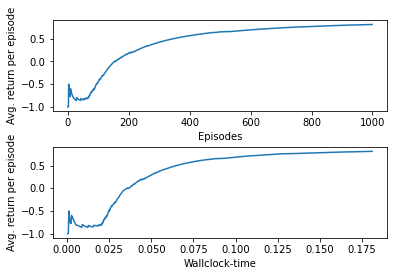

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(2,1,1)
plt.plot(np.arange(episodes), rpe);
plt.xlabel('Episodes');
plt.ylabel('Avg. return per episode');
plt.subplot(2,1,2)
plt.plot(times, rpe);
plt.xlabel('Wallclock-time');
plt.ylabel('Avg. return per episode');
plt.subplots_adjust(hspace=0.4)

every step safe (s,a,r,s')

s and a are the old values (safe them!), s' the new value that comes out after doing a step

when reaching the final state, what is s' then?

r is the reward of this time step (how do I determine r?)

-> is it just 0 for every step until the last?

if so, do the Q_values just update themselfs based on the next Q_value without reward?

do I play a complete game first before updating Q_values?

When calculating Sarsa, I use the next Q_value to calculate the old one, where do I get the next action from?

If I take it from the episode list I iterate through, what do I do with the first entry that has no next action?

-> I just took the action with the highest Q_value, just like we would have picked with argmax in the next step
